# Interconnect: Pronóstico de cancelación de clientes.

Modelo de predicción de cancelación de clientes. Utiliza información sobre los servicios contratados y el historial de cancelaciones para entrenar modelos de machine learning, optimizados para maximizar la métrica AUC ROC.

## 0. Inicialización

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import inflection

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

warnings.filterwarnings("ignore")
random = 12345

## 1. Funciones

### Cargar y unir datos

- Cargar los cuatro archivos csv con datos: contract.csv, internet.csv, personal.csv y phone.csv.
- Unir los datos en un solo DataFrame por customerID.
- Verificar duplicados y consistencia de IDs.

In [2]:
def load_and_merge(contract_path='data/contract.csv',
                   internet_path='data/internet.csv',
                   personal_path='data/personal.csv',
                   phone_path='data/phone.csv'):

    contract = pd.read_csv(contract_path, parse_dates=[
                           'BeginDate'], dayfirst=True)
    contract['EndDate'] = pd.to_datetime(
        contract['EndDate'], errors='coerce', dayfirst=True)
    internet = pd.read_csv(internet_path)
    personal = pd.read_csv(personal_path)
    phone = pd.read_csv(phone_path)

    # Merge por customerID
    df = contract.merge(personal, on='customerID', how='left') \
                 .merge(internet, on='customerID', how='left') \
                 .merge(phone, on='customerID', how='left')

    # Verificar duplicados y consistencia de IDs
    dup_ids = df['customerID'][df['customerID'].duplicated()]
    if len(dup_ids) > 0:
        print(f"WARNING: {len(dup_ids)} customerID duplicados (muestra):")
        print(dup_ids.unique()[:10])
    else:
        print("No se detectaron customerID duplicados.")

    return df

### Explorar los datos

- Explorar los datos: primeras filas (head()), tamaño (shape), tipos de columnas (info()) y missing values (isna().sum()).

In [3]:
def info(df):
    print("\n------------ Head del DataFrame ------------")
    print(df.head())
    print("\n------------ Shape ------------")
    print(df.shape)
    print("\n------------ -Info -----------")
    print(df.info())
    print("\n------------ % Missing values ------------")
    print((df.isna().mean() * 100).sort_values(ascending=False).head(20))

    return

### Preprocesamiento

- Limpiar y convertir columnas si es necesario.
- Crear variable objetivo Churn: 1 si existe EndDate, 0 si no.
- Crear variable tenure_months: tiempo del cliente desde BeginDate hasta 1 de febrero de 2020 o hasta EndDate.

In [4]:
def preprocess(df):
    ref_date = pd.to_datetime("2020-01-02")  # referencia para tenure
    df = df.copy()
    df.columns = [inflection.underscore(col) for col in df.columns]

    # TotalCharges a numérico
    df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')
    df['total_charges'] = df['total_charges'].fillna(0)

    # Crear target churn: 1 si existe EndDate
    df['churn'] = df['end_date'].notna().astype(int)

    # tenure_months: desde BeginDate hasta EndDate (si existe) o hasta ref_date
    df['tenure_end'] = df['end_date'].fillna(ref_date)
    df['tenure_days'] = (df['tenure_end'] - df['begin_date']).dt.days
    df['tenure_months'] = (df['tenure_days'] / 30).clip(lower=0)
    df.drop(columns=['tenure_end', 'tenure_days', 'begin_date',
            'end_date', 'customer_id'], inplace=True)

    # Rellenar servicios faltantes con 'No' (dado que NaN implica ausencia de servicio)
    missing_cols = [col for col in df.columns if df[col].isnull(
    ).any() and df[col].dtype == 'object']
    # service_cols = ['internet_service','online_security','online_backup','device_protection','tech_support','StreamingTV','StreamingMovies','MultipleLines']
    for c in missing_cols:
        df[c] = df[c].fillna('No')

    return df

### EDA

- Analizar la distribución de la variable objetivo (churn) y calcular el balance de clases.
- Distribución de variables numéricas (MonthlyCharges, TotalCharges, tenure_months) por churn.
- Distribución de variables categóricas (contrato, método de pago, InternetService, etc.) por churn.

In [5]:
def eda(df):
    sns.set_theme(style="whitegrid", palette="pastel")

    print("\n----------- EDA sobre target ------------")
    print(df['churn'].value_counts(dropna=False))
    print("\nProporción churn:", df['churn'].mean())

    # Churn distribution
    plt.figure(figsize=(16, 5))
    sns.countplot(x='churn', data=df)
    plt.title('Distribución de churn', fontsize=14)
    plt.show()

    # Separar columnas numéricas y categóricas
    num_cols = df.select_dtypes(include=['float64']).columns.drop(
        'churn', errors='ignore')
    cat_cols = df.select_dtypes(
        include=['object', 'category', 'bool']).columns.drop('churn', errors='ignore')

    # Variables numéricas
    for i in range(0, len(num_cols), 3):
        subset = num_cols[i:i+3]
        fig, axes = plt.subplots(1, len(subset), figsize=(16, 5))
        if len(subset) == 1:
            axes = [axes]
        for ax, col in zip(axes, subset):
            sns.histplot(data=df, x=col, hue='churn', kde=True,
                         stat='density', common_norm=False, ax=ax)
            ax.set_title(f'{col} por churn', fontsize=12)
        plt.tight_layout()
        plt.show()

    # Variables categóricas
    for i in range(0, len(cat_cols), 3):
        subset = cat_cols[i:i+3]
        fig, axes = plt.subplots(1, len(subset), figsize=(16, 5))
        if len(subset) == 1:
            axes = [axes]
        for ax, col in zip(axes, subset):
            ct = pd.crosstab(df[col], df['churn'], normalize='index')
            ct.plot(kind='bar', stacked=True, ax=ax,
                    color=sns.color_palette("pastel"))
            ax.set_title(f'Churn por {col}', fontsize=12)
            ax.set_ylabel('Proporción')
            ax.legend(title='churn')
        plt.tight_layout()
        plt.show()

### Dividir los datos

- Separar variables en numéricas y categóricas.
- Dividir los datos en train, validation y test (proporción 3:1:1) estratificando por churn para preservar la proporción de clases.

In [6]:
def split(df, random_state=random):
    # Columnas numéricas y categóricas
    num_features = df.select_dtypes(include=['float64', 'int64']).columns.drop(
        'churn', errors='ignore')
    cat_features = df.select_dtypes(
        include=['object', 'category', 'bool']).columns.drop('churn', errors='ignore')

    X = df[cat_features.union(num_features)]
    y = df['churn']

    # Split train, val, test (60%, 20%, 20%) estratificado por churn
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test, cat_features, num_features

### Construir preprocesador

- Crear pipelines de preprocesamiento:
    - Escalamiento de variables numéricas (StandardScaler).
    - One-Hot Encoding de variables categóricas (OneHotEncoder).
- Asegurar que cada pipeline se aplique solo sobre los datos de entrenamiento para evitar data leakage.

In [7]:
def build_preprocessor(num_features, cat_features):
    # Pipeline numérico: solo escalado
    num_pipeline = Pipeline(steps=[('scaler', StandardScaler())])

    # Pipeline categórico: solo one-hot con drop de la primera categoría
    cat_pipeline = Pipeline(
        steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))])

    # ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[(
        'num', num_pipeline, num_features), ('cat', cat_pipeline, cat_features)])

    return preprocessor

### Ajustar modelo

- Ajustar modelos
- Obtener AUC-ROC como métrica principal y exactitud como métrica secundaria.
- Devolver un diccionario con los resultadis de las métricas y fpr + tpr.

In [8]:
def fit_model(pipe, results, name, X_train, y_train, X_val, y_val):

    model = pipe.fit(X_train, y_train)

    # Si es RandomizedSearchCV, usar el best_estimator_ para guardar
    if hasattr(model, "best_estimator_"):
        model = model.best_estimator_
    else:
        model = model

    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)
    fpr, tpr, thresholds = roc_curve(y_val, y_proba)
    results[name] = {
        'model': model,
        'auc': roc_auc_score(y_val, y_proba),
        'acc': accuracy_score(y_val, y_pred),
        'fpr': fpr,
        'tpr': tpr
    }

    return results

### Graficar la curva AUC-ROC

In [9]:
def plot_auc(results_dict):
    sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

    model_names = list(results_dict.keys())
    n_models = len(model_names)

    for i in range(0, n_models, 3):
        subset = model_names[i:i+3]
        fig, axes = plt.subplots(1, len(subset), figsize=(16, 5))
        if len(subset) == 1:
            axes = [axes]

        for ax, name in zip(axes, subset):
            data = results_dict[name]
            fpr = data.get('fpr', [])
            tpr = data.get('tpr', [])
            auc_val = data.get('auc', None)
            acc_val = data.get('acc', None)

            # Graficar curva AUC-ROC
            sns.lineplot(x=fpr, y=tpr, ax=ax, linewidth=2.2,
                         label=f"AUC = {auc_val:.4f}")
            ax.plot([0, 1], [0, 1], 'k--', lw=1, label="Aleatorio")

            # Etiquetas
            title = f"{name}"
            if acc_val is not None:
                title += f"\nAcc = {acc_val:.4f}"
            ax.set_title(title, fontsize=13, fontweight='bold')

            ax.set_xlabel("Tasa de falsos positivos (FPR)")
            ax.set_ylabel("Tasa de verdaderos positivos (TPR)")
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 1.05])
            ax.legend(loc="lower right")

        plt.tight_layout()
        plt.show()

### Obtener el mejor modelo

In [10]:
def best_model(*results_dicts):
    best_auc = -1
    best_acc = -1
    best_model = None
    best_name = None

    # Iterar sobre todos los diccionarios
    for results in results_dicts:
        for name, res in results.items():
            if res['auc'] > best_auc:
                best_auc = res['auc']
                best_acc = res['acc']
                best_model = res['model']
                best_name = name

    return best_model, best_auc, best_acc, best_name

## 2. Estructura del proyecto

### 2.1 Carga y unión de los datos

In [11]:
df = load_and_merge()
info(df)

No se detectaron customerID duplicados.

------------ Head del DataFrame ------------
   customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01        NaT  Month-to-month              Yes   
1  5575-GNVDE 2017-01-04        NaT        One year               No   
2  3668-QPYBK 2019-01-10 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-01-05        NaT        One year               No   
4  9237-HQITU 2019-01-09 2019-11-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  gender  \
0           Electronic check           29.85        29.85  Female   
1               Mailed check           56.95       1889.5    Male   
2               Mailed check           53.85       108.15    Male   
3  Bank transfer (automatic)           42.30      1840.75    Male   
4           Electronic check           70.70       151.65  Female   

   SeniorCitizen Partner Dependents InternetService OnlineSecurity

### 2.2 Preprocesamiento de los datos

In [12]:
df = preprocess(df)
info(df)


------------ Head del DataFrame ------------
             type paperless_billing             payment_method  \
0  Month-to-month               Yes           Electronic check   
1        One year                No               Mailed check   
2  Month-to-month               Yes               Mailed check   
3        One year                No  Bank transfer (automatic)   
4  Month-to-month               Yes           Electronic check   

   monthly_charges  total_charges  gender  senior_citizen partner dependents  \
0            29.85          29.85  Female               0     Yes         No   
1            56.95        1889.50    Male               0      No         No   
2            53.85         108.15    Male               0      No         No   
3            42.30        1840.75    Male               0      No         No   
4            70.70         151.65  Female               0      No         No   

  internet_service online_security online_backup device_protection  \
0     

### 2.3 EDA


----------- EDA sobre target ------------
churn
0    5174
1    1869
Name: count, dtype: int64

Proporción churn: 0.2653698707936959


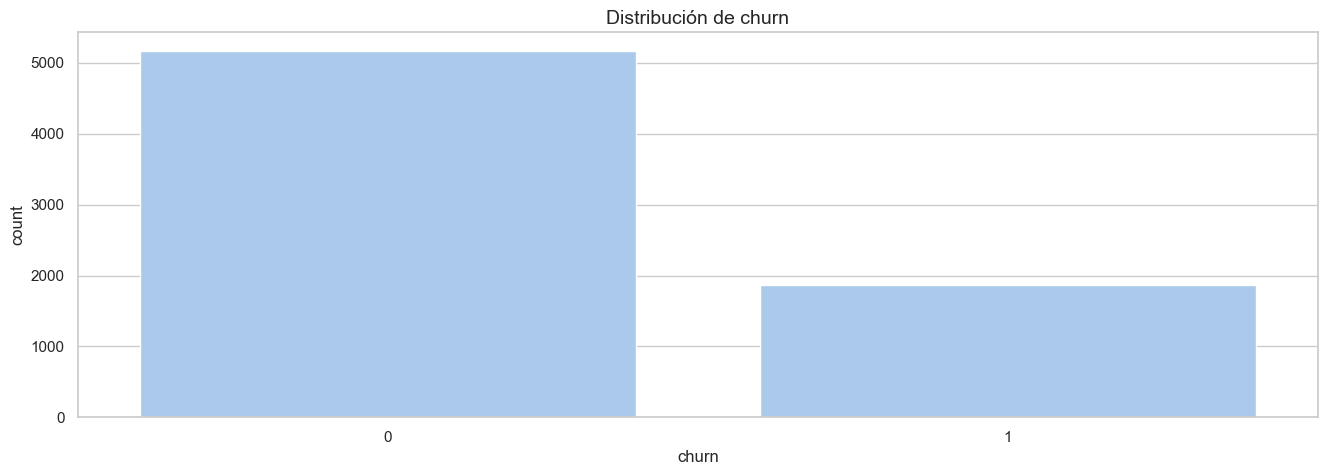

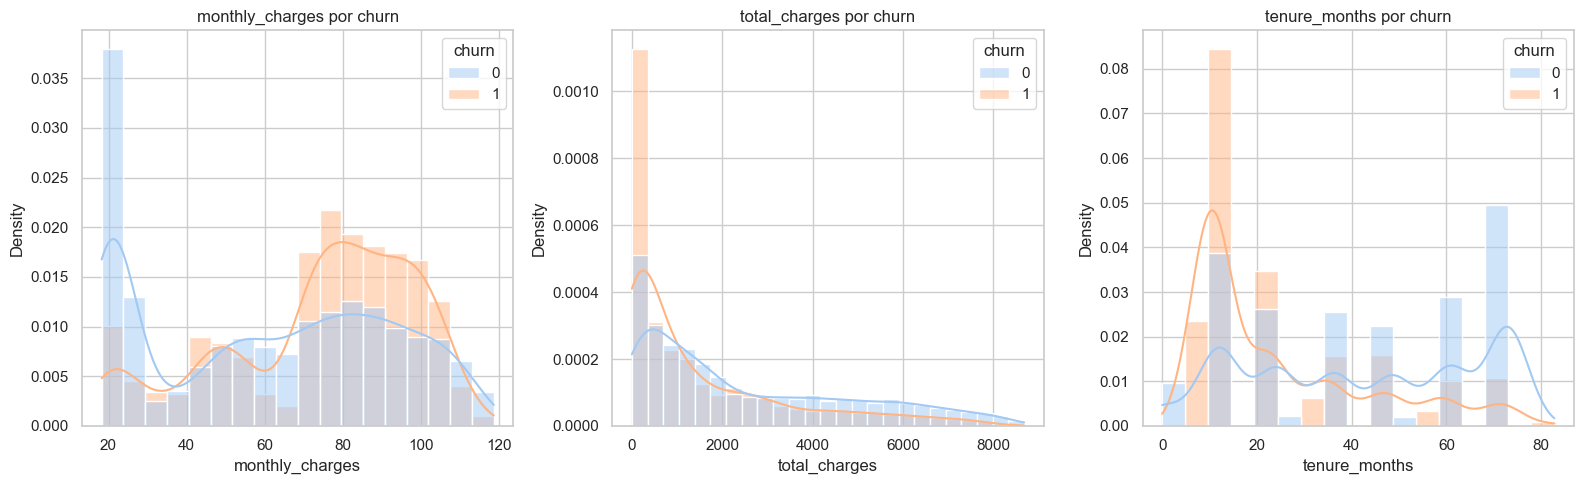

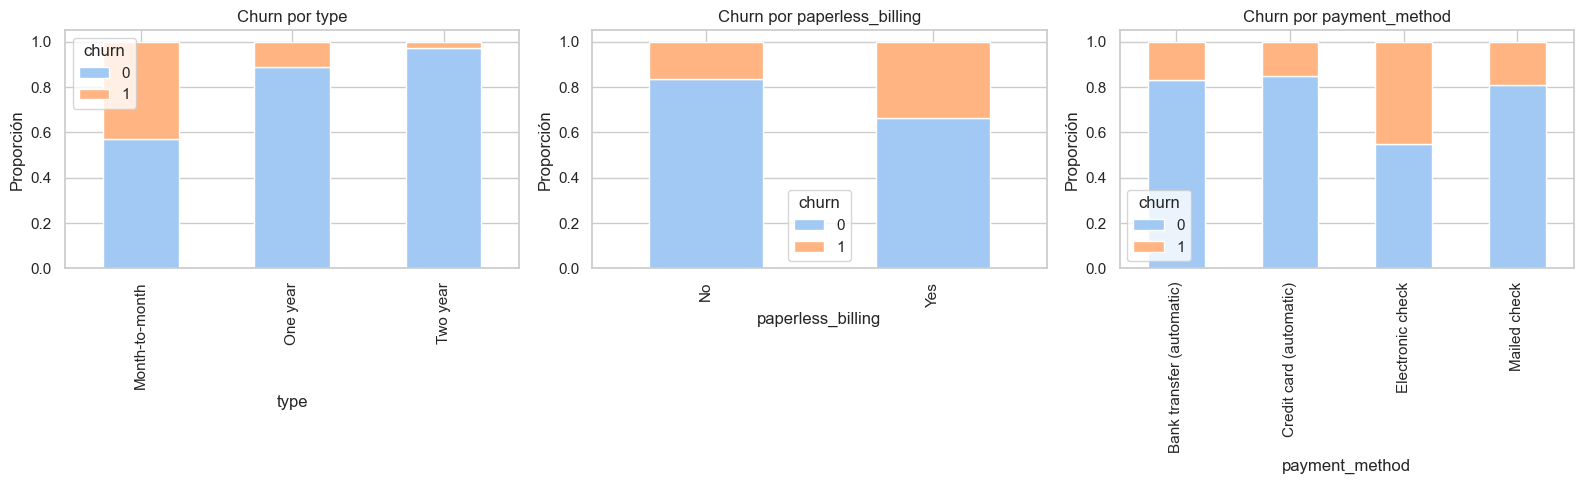

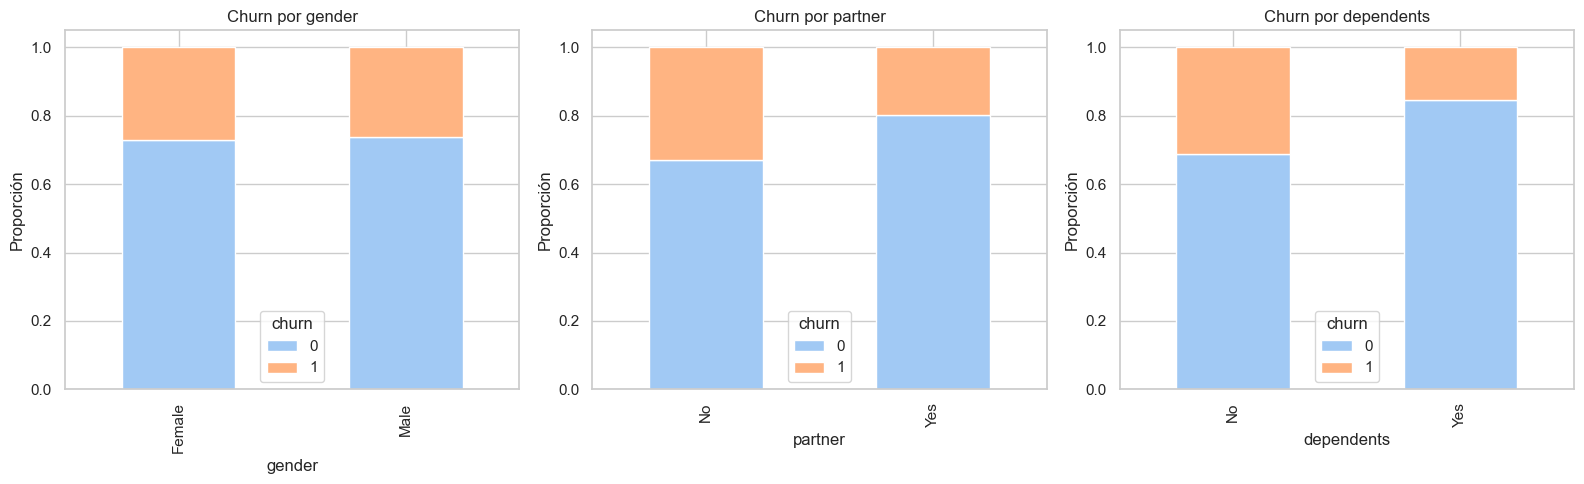

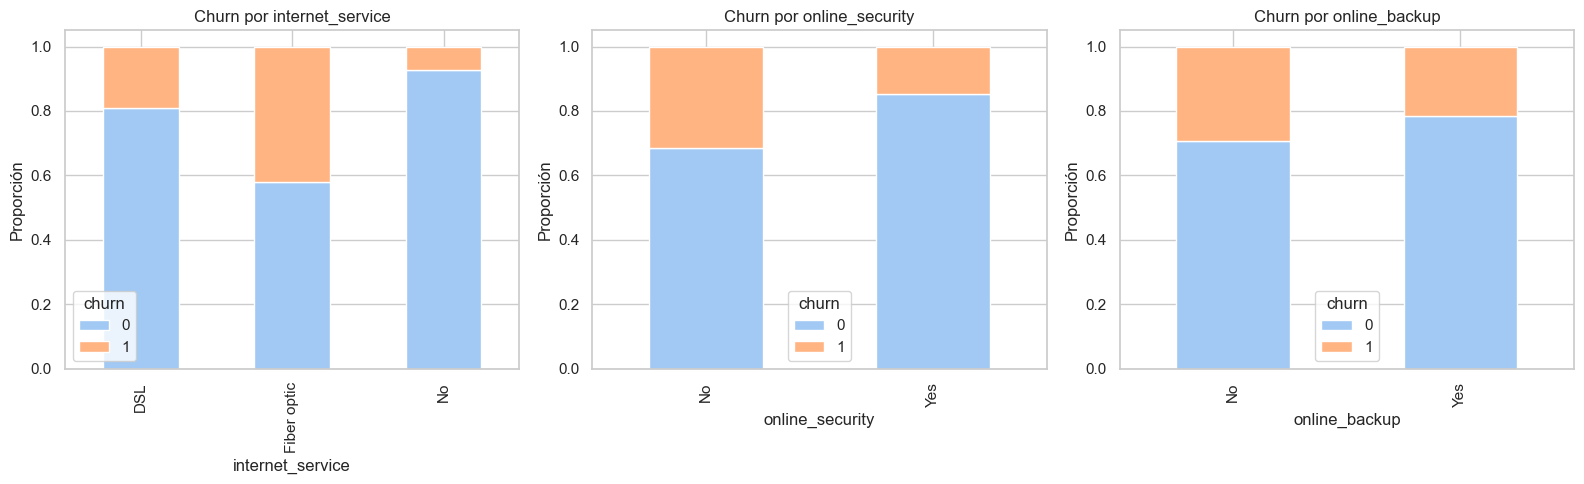

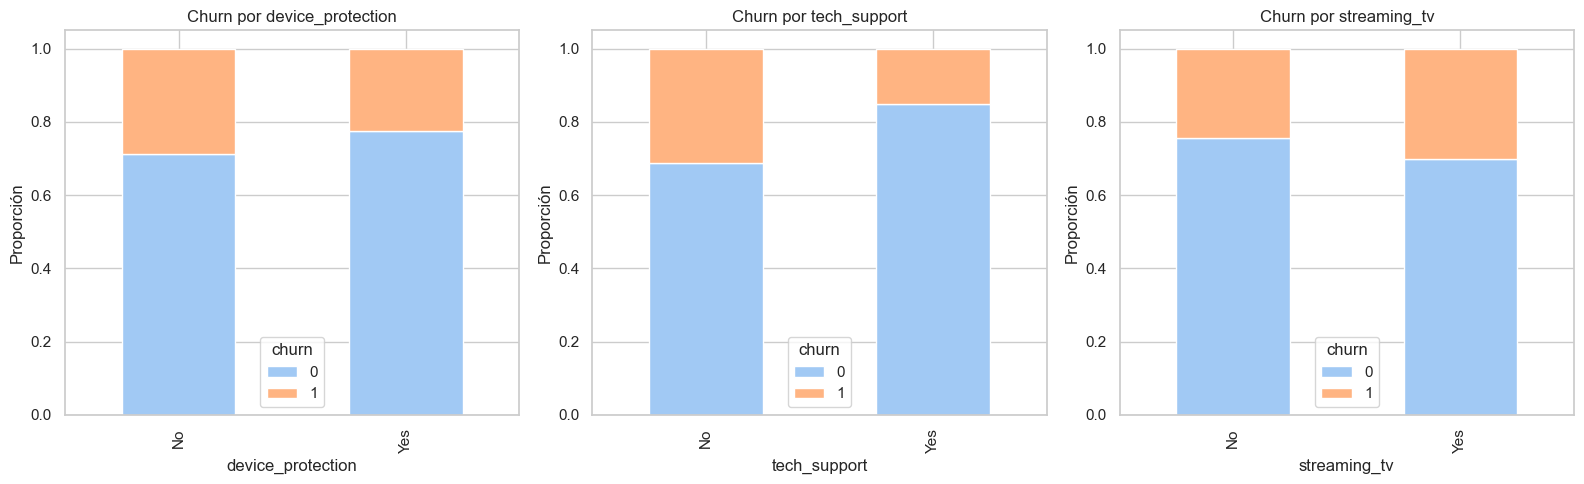

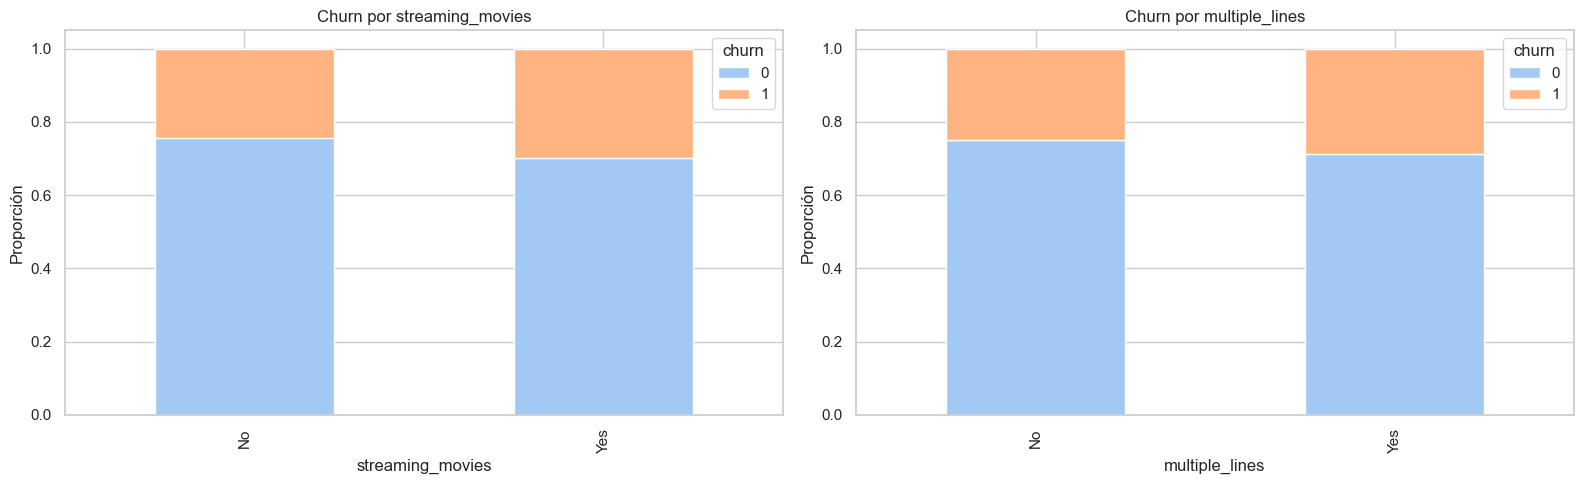

In [13]:
eda(df)

### 2.4 Preparar los datos

In [14]:
# Split data
X_train, X_val, X_test, y_train, y_val, y_test, cat_features, num_features = split(
    df)
# Preprocessor
preprocessor = build_preprocessor(num_features, cat_features)

### 2.5 Modelos sin tener en cuenta el desequilibrio de clases

Se crearon 3 modelos:
- Modelo Dummy
- Random Forest
- LightGBM

In [15]:
models = {
    "Dummy": Pipeline([
        ('preproc', preprocessor),
        ('clf', DummyClassifier(strategy='most_frequent'))
    ]),
    "RandomForest": Pipeline([
        ('preproc', preprocessor),
        ('clf', RandomForestClassifier(
            n_estimators=200, random_state=random, n_jobs=-1))
    ]),
    "LightGBM": Pipeline([
        ('preproc', preprocessor),
        ('clf', lgb.LGBMClassifier(
            n_estimators=200, random_state=random, verbose=-1))
    ])
}

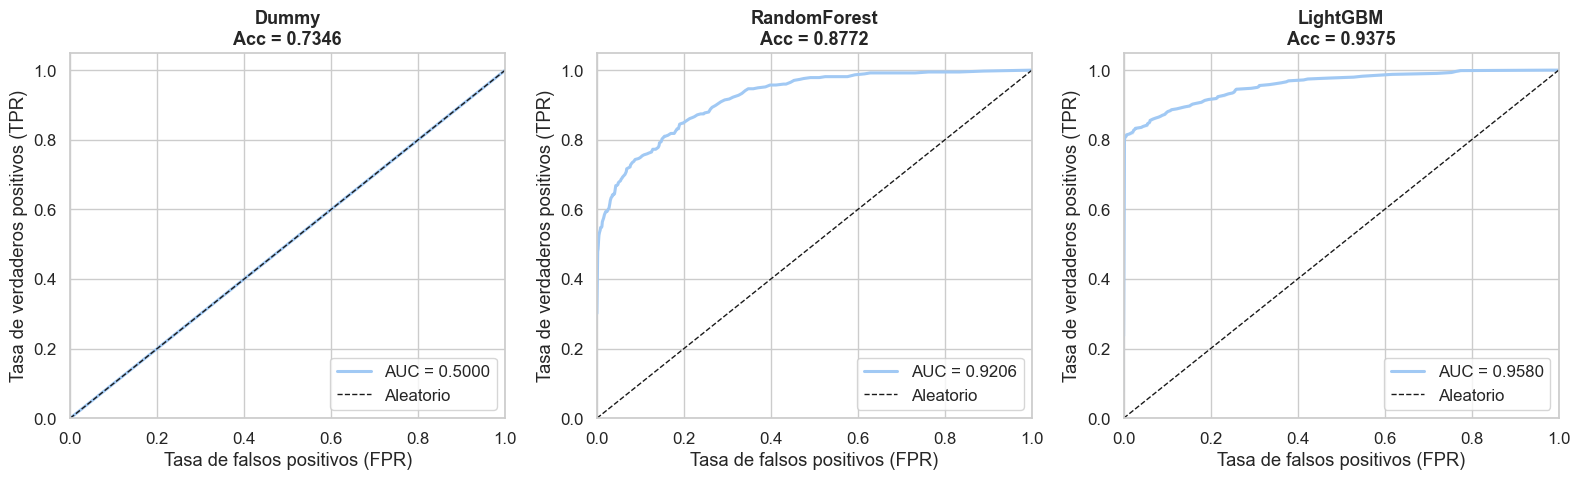

In [16]:
results = {}

for name, model in models.items():
    results = fit_model(model, results, name, X_train, y_train, X_val, y_val)

plot_auc(results)

### 2.6 Mejora de modelos

- Aplicar técnicas de balanceo de clases:
    - SMOTE (oversampling) para la clase minoritaria (churn).

In [17]:
smote_models = {
    "SMOTE_RandomForest": ImbPipeline([
        ('preproc', preprocessor),
        ('smote', SMOTE(random_state=random)),
        ('clf', RandomForestClassifier(
            n_estimators=200, random_state=random, n_jobs=-1))
    ]),
    "SMOTE_LightGBM": ImbPipeline([
        ('preproc', preprocessor),
        ('smote', SMOTE(random_state=random)),
        ('clf', lgb.LGBMClassifier(
            n_estimators=200, random_state=random, verbose=-1))
    ])
}

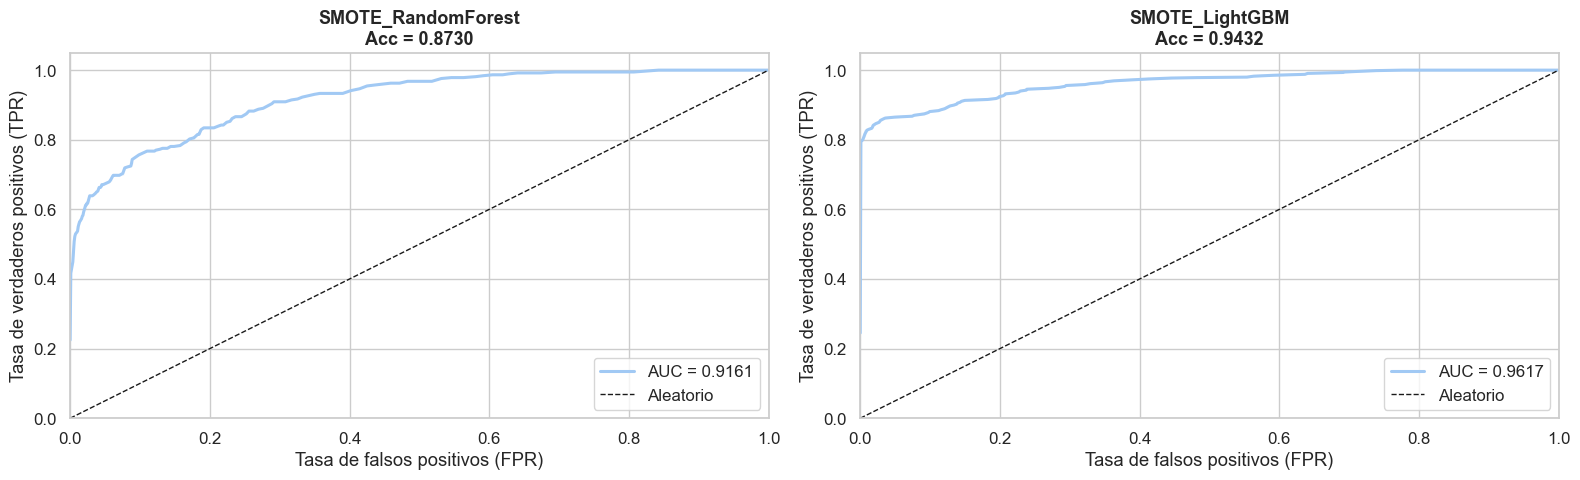

In [18]:
results_smote = {}
for name, model in smote_models.items():
    results_smote = fit_model(
        model, results_smote, name, X_train, y_train, X_val, y_val)

plot_auc(results_smote)

### 2.7 Validación y tuning

- Usar StratifiedKFold cross-validation para evaluar modelos robustamente.
- Optimizar hiperparámetros de modelos con RandomizedSearchCV usando AUC-ROC como métrica principal.

In [19]:
param_grid = {
    "SMOTE_RandomForest": {
        "clf__n_estimators": [100, 200, 300],
        "clf__max_depth": [None, 5, 10],
        "clf__min_samples_split": [2, 5, 10]
    },
    "SMOTE_LightGBM": {
        "clf__num_leaves": [31, 50, 70],
        "clf__learning_rate": [0.01, 0.05, 0.1],
        "clf__n_estimators": [100, 200, 300]
    }
}

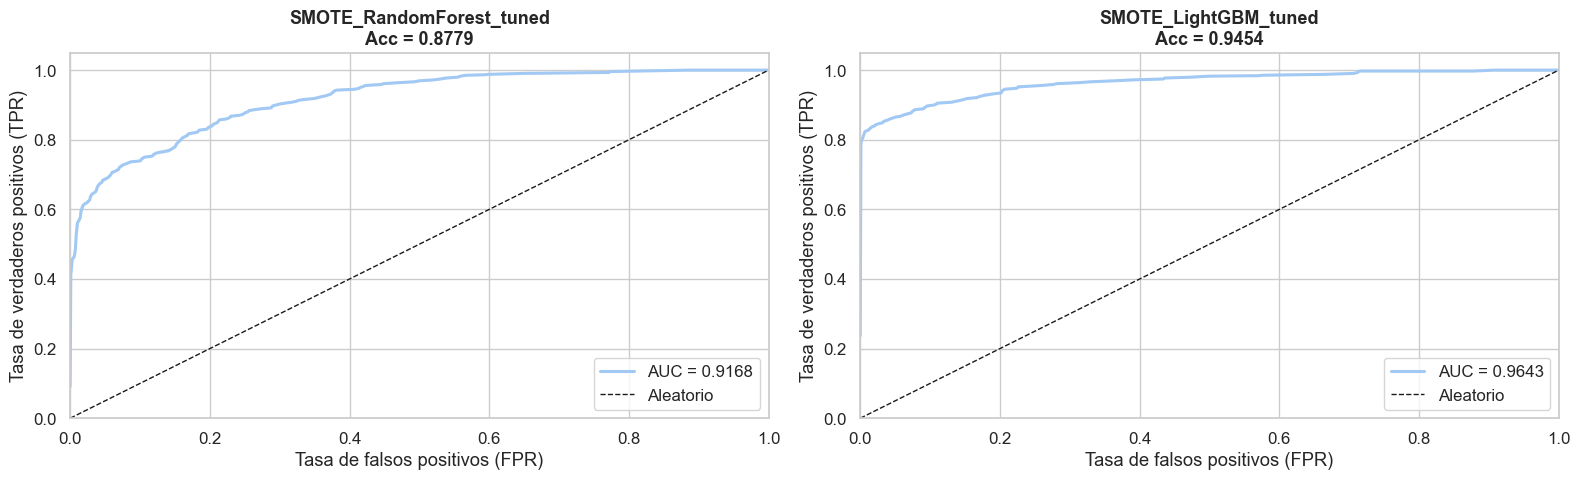

In [20]:
results_cv = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random)

for name, model in smote_models.items():
    clf = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid[name],
        n_iter=10,
        scoring='roc_auc',
        cv=cv,
        n_jobs=-1,
        verbose=0,
        random_state=random
    )
    results_cv = fit_model(
        clf, results_cv, name + "_tuned", X_train, y_train, X_val, y_val)

plot_auc(results_cv)

### 2.8 Probar el mejor modelo en test

El mejor modelo es SMOTE_LightGBM_tuned
Validation: AUC = 0.9643, Acc = 0.9454
Test: AUC = 0.9640, Acc = 0.9390


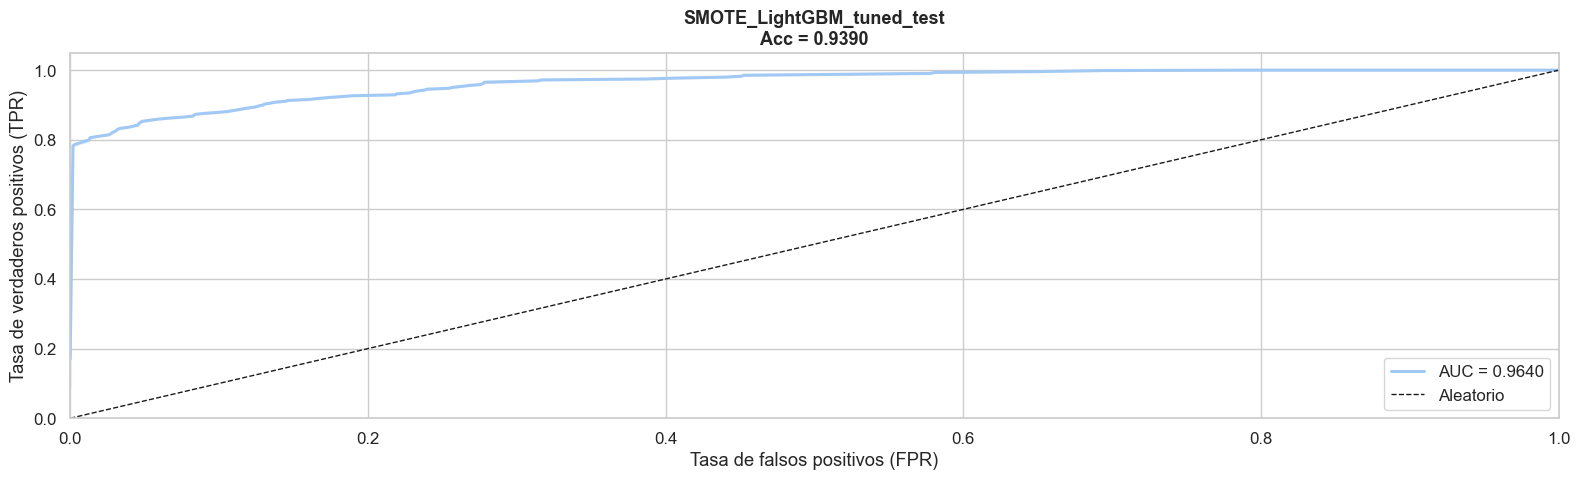

In [21]:
# Obtener el mejor modelo
best_model, best_auc, best_acc, best_name = best_model(
    results, results_smote, results_cv)

# Probarlo con dataset de test
y_proba_test = best_model.predict_proba(X_test)[:, 1]
y_pred_test = best_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
results_test = {best_name+"_test": {'auc': roc_auc_score(y_test, y_proba_test),
                                    'acc': accuracy_score(y_test, y_pred_test),
                                    'fpr': fpr,
                                    'tpr': tpr
                                    }}

print(f"El mejor modelo es {best_name}")
print(f"Validation: AUC = {best_auc:.4f}, Acc = {best_acc:.4f}")
print(
    f"Test: AUC = {results_test[best_name+'_test']['auc']:.4f}, Acc = {results_test[best_name+'_test']['acc']:.4f}")

plot_auc(results_test)